# Run an HLS composite data search quickly on a tile

This notebook provides an example of how to:
 - run a quick search to check # of available HLS scenes for a HLS seasonal greenest pixel composite on a focal tile  
 - run that a composite  
 
Each tile is 3000 x 3000 pixels at 30 m resolution

Paul Montesano, PhD

In [13]:
import os, sys
ICESAT2_BOREAL_REPO_PATH = '/projects/code/icesat2_boreal/lib' 
sys.path.append(ICESAT2_BOREAL_REPO_PATH)

In [67]:
import geopandas as gpd
import pandas as pd

import datetime

import json
import glob

import s3fs
import numpy as np
s3 = s3fs.S3FileSystem(anon=False)

In [87]:
FOCAL_TILE = 3823

#### HLS composite parameters

In [110]:
YEAR = 2020
SEASON_START = '07-01'
SEASON_STOP = '08-31' 
MAX_CLOUDS = 25
MS_DATA_TYPE = 'HLS'

In [111]:
INDEX_FN =  'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004_model_ready.gpkg'
INDEX_LYR = 'boreal_tiles_v004_model_ready'
SAT_API = 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD'
OUTDIR = '/projects/my-private-bucket/tmp'

args = f"-i {INDEX_FN} \
-lyr {INDEX_LYR} \
-a {SAT_API} \
--tile_buffer_m 0 \
--in_tile_num {FOCAL_TILE} \
-o {OUTDIR} \
-sy {YEAR} -ey {YEAR} -smd {SEASON_START} -emd {SEASON_STOP} -mc {MAX_CLOUDS} \
--composite_type {MS_DATA_TYPE} \
--hls_product H30 \
--rangelims_red 0 1 \
--thresh_min_ndvi -1"

### Run HLS search only 
this is fast - no compositing - it tells you how many HLS scenes are available for this tile based on parameters

In [112]:
cmd = f'python /projects/code/icesat2_boreal/lib/3.1.2_dps.py {args} --search_only'
!echo $cmd
!eval $cmd

python /projects/code/icesat2_boreal/lib/3.1.2_dps.py -i https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004_model_ready.gpkg -lyr boreal_tiles_v004_model_ready -a https://cmr.earthdata.nasa.gov/stac/LPCLOUD --tile_buffer_m 0 --in_tile_num 3823 -o /projects/my-private-bucket/tmp -sy 2020 -ey 2020 -smd 07-01 -emd 08-31 -mc 25 --composite_type HLS --hls_product H30 --rangelims_red 0 1 --thresh_min_ndvi -1 --search_only

Tiles path:		 https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004_model_ready.gpkg
Tile number:		 3823
Output res (m):		 30
in_bbox:		 [-81478.00000000466, 2673304.0000000093, -0.46874016203220914, 2763304.0000000093]
bbox 4326:		 [178.2621539860503, 64.00454437333856, 179.99999, 64.80974254538371]
Getting output dims from buffered (buffer=0.0) original tile geometry...
Output dims:		3000 x 2715
Composite type:		HLS

Getting HLS data...
bbox: [178.2621539860503, 64.00454437333856, 179.99999, 64.809742

### Plot some HLS metadata for the scene query returned above

In [113]:
hls_json_meta_list = [f'/projects/my-private-bucket/tmp/master_{FOCAL_TILE}_{YEAR}-{SEASON_START}_{YEAR}-{SEASON_STOP}_HLS.json']
hls_json_meta_list[0]

'/projects/my-private-bucket/tmp/master_3823_2020-07-01_2020-08-31_HLS.json'

In [114]:
%%time

gdf_list = []
df_list = []
df_smry_list = []
fn_not_found_list=[]

def season_classifier(row):
    if '01' in row["start_month"]:
        return "wet"
    else:
        return "dry"

for fn in hls_json_meta_list:
    
    # Cant make gdf and df during one single open...
    try:
        with open(fn) as f:

            # Build geodataframes
            gdf = gpd.GeoDataFrame.from_features(json.load(f), crs=4326)
            gdf_list.append(gdf)

        with open(fn) as f:

            # Build dataframe of attributes
            df = pd.json_normalize(json.load(f), record_path=['features'])
            #df['datetime'] = pd.to_datetime(df.id.str.split('.', expand=True)[3], format='%Y%jT%H%M%S')
            #df['doy'] = df['datetime'].dt.dayofyear
            df['filename'] = os.path.basename(fn)
            df['start'] = os.path.basename(fn).split('_')[2]
            df['start_month'] = os.path.basename(fn).split('_')[2].split('-')[1]
            df['year'] = os.path.basename(fn).split('_')[2].split('-')[0]
            df['season'] = 'none'
            if False:
                df['season'] = df.apply(season_classifier, axis=1)
            df['end'] = os.path.basename(fn).split('_')[3]
            df_smry = df.groupby(['filename','year','season']).size().reset_index(name='counts')
            df_list.append(df)
            df_smry_list.append(df_smry)
    except:
        print(f'File not found: {fn}')
        fn_not_found_list.append(fn)

df = pd.concat(df_list)
df_smry = pd.concat(df_smry_list)
df_smry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1 non-null      object
 1   year      1 non-null      object
 2   season    1 non-null      object
 3   counts    1 non-null      int64 
dtypes: int64(1), object(3)
memory usage: 160.0+ bytes
CPU times: user 44.3 ms, sys: 2.3 ms, total: 46.6 ms
Wall time: 64.4 ms


### Geodataframe show all the pieces of HLS scenes from the search above
duplicate HLS scenes indicate where scenes were used for multiple tiles

In [115]:
%%time
hls_scene_part_gdf = pd.concat([pd.concat(gdf_list), pd.concat(df_list)], axis=1)
hls_scene_part_gdf.drop( [c for c in hls_scene_part_gdf.columns for s in ['assets','links','properties'] if s in c], axis=1, inplace=True)

CPU times: user 6.91 ms, sys: 0 ns, total: 6.91 ms
Wall time: 6.17 ms


In [116]:
hls_scene_part_gdf.shape

(27, 19)

In [117]:
hls_scene_part_gdf.groupby('id').agg({'id':['count']}).shape

(27, 1)

In [118]:
hls_scene_gdf = hls_scene_part_gdf.dissolve(by='id')

In [119]:
hls_scene_gdf['datetime'] = pd.to_datetime(hls_scene_gdf['datetime'])
hls_scene_gdf['doy'] = pd.to_datetime(hls_scene_gdf['datetime']).dt.dayofyear

In [120]:
hls_scene_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 27 entries, HLS.L30.T01WCM.2020190T233436.v2.0 to HLS.S30.T60WWS.2020207T234629.v2.0
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   geometry              27 non-null     geometry           
 1   datetime              27 non-null     datetime64[ns, UTC]
 2   eo:cloud_cover        27 non-null     int64              
 3   start_datetime        27 non-null     object             
 4   end_datetime          27 non-null     object             
 5   type                  27 non-null     object             
 6   stac_version          27 non-null     object             
 7   stac_extensions       27 non-null     object             
 8   bbox                  27 non-null     object             
 9   collection            27 non-null     object             
 10  geometry.type         27 non-null     object             
 11  geome

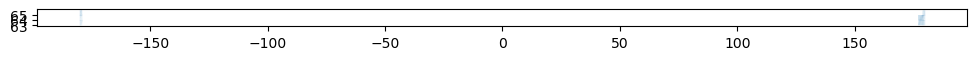

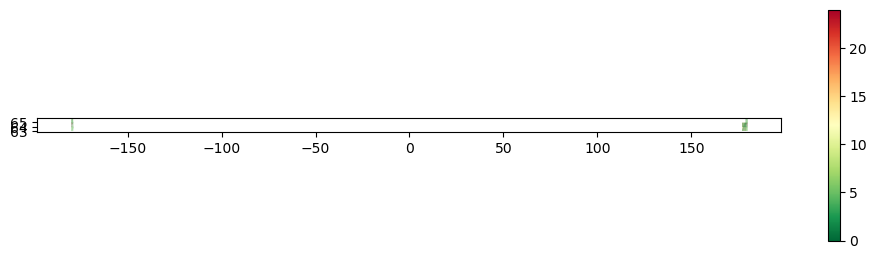

In [121]:
hls_scene_gdf.plot(alpha=0.05, legend=True, figsize=(12,3))
ax = hls_scene_gdf.plot(column='eo:cloud_cover', alpha=0.25, cmap='RdYlGn_r', legend=True, figsize=(12,3))

### Run HLS composite 
if params return:  
`>` ~100 scenes maybe this could take 15-25 mins?  
`>` ~175 scenes maybe too much for 32Gb of RAM?

In [122]:
%%time
cmd = f'python /projects/code/icesat2_boreal/lib/3.1.2_dps.py {args}'
!echo $cmd
!eval $cmd

python /projects/code/icesat2_boreal/lib/3.1.2_dps.py -i https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004_model_ready.gpkg -lyr boreal_tiles_v004_model_ready -a https://cmr.earthdata.nasa.gov/stac/LPCLOUD --tile_buffer_m 0 --in_tile_num 3823 -o /projects/my-private-bucket/tmp -sy 2020 -ey 2020 -smd 07-01 -emd 08-31 -mc 25 --composite_type HLS --hls_product H30 --rangelims_red 0 1 --thresh_min_ndvi -1

Tiles path:		 https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004_model_ready.gpkg
Tile number:		 3823
Output res (m):		 30
in_bbox:		 [-81478.00000000466, 2673304.0000000093, -0.46874016203220914, 2763304.0000000093]
bbox 4326:		 [178.2621539860503, 64.00454437333856, 179.99999, 64.80974254538371]
Getting output dims from buffered (buffer=0.0) original tile geometry...
Output dims:		3000 x 2715
Composite type:		HLS

Getting HLS data...
bbox: [178.2621539860503, 64.00454437333856, 179.99999, 64.80974254538371]

Que

## Plot the HLS composite created above

In [123]:
import plotlib
import rasterio
from rasterio.plot import show_hist, show
import numpy as np
import matplotlib.pyplot as plt

In [124]:
import importlib
importlib.reload(plotlib)

<module 'plotlib' from '/projects/code/icesat2_boreal/lib/plotlib.py'>

In [125]:
#YEAR = 2014

In [126]:
fn = f'/projects/my-private-bucket/tmp/HLS_{FOCAL_TILE}_{SEASON_START}_{SEASON_STOP}_{YEAR}_{YEAR}.tif'

In [127]:
outdir = os.path.dirname(fn)
rescaled_multiband_fn = os.path.join(outdir, os.path.basename(fn).replace('.tif','_rescaled_3band_temp.tif'))
print(rescaled_multiband_fn)
plotlib.rescale_multiband_for_plot(fn, rescaled_multiband_fn, bandlist = [6,4,3], pct=[25,85], nodata=-9999.0) 

/projects/my-private-bucket/tmp/HLS_3823_07-01_08-31_2020_2020_rescaled_3band_temp.tif


TypeError: /projects/my-private-bucket/tmp/HLS_3823_07-01_08-31_2020_2020.tif: Transport endpoint is not connected

In [ ]:
fig,ax=plt.subplots(figsize=(15,15))
with rasterio.open(rescaled_multiband_fn) as src:
    show(src.read(),transform=src.transform, ax=ax, title=os.path.basename(fn))